In [1]:
# compute cluster energy resolution
import os
import glob
import uproot
import awkward as ak
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import helper functions
from root_data_loader import load_root_file_chunked, validate_cluster_counts, flatten_to_dataframe

# ============================================================================
# Selections
# ============================================================================
E_MIN = 300  # Minimum true energy for clusters to be considered
Eta_MAX = 2.5  # Maximum absolute eta for clusters

# ============================================================================
# Load and prepare data (with chunking)
# ============================================================================

# Configuration
file_pattern = "/mnt/nvme0n1p4/HEP/Work/Project-W-Z/MotorHead/quicktree2histo/plot-recoil/root-files/outTree_zmumu_withPU_merged.root"
tree_name = "treeAnaWZ"
branches = ["fCluster_truthE", "fCluster_rawE", "fCluster_calE", "fCluster_MLE", "fClusterEta", "npv"]
n_events = None # Process all events
chunk_size = 10000

# Branch mapping
branch_mapping = {
    "fCluster_truthE": "fCluster_truthE",
    "fCluster_rawE": "fCluster_rawE",
    "fCluster_calE": "fCluster_calE",
    "fCluster_MLE": "fCluster_MLE",
    "fClusterEta": "fClusterEta"
}

# Process all chunks and concatenate
all_dfs = []
for chunk_arr in load_root_file_chunked(file_pattern, tree_name, branches, 
                                        chunk_size=chunk_size, n_events=n_events):
    # Validate cluster counts
    validate_cluster_counts(chunk_arr, branches[:-1]) # Exclude 'npv' from validation
    
    # Flatten to DataFrame (cluster branches only)
    cluster_mapping = {k: v for k, v in branch_mapping.items() if k in chunk_arr.fields}
    df_chunk = flatten_to_dataframe(chunk_arr, cluster_mapping)
    
    # Add event-level quantity: repeat npv for each cluster in that event
    npv_per_event = np.array(chunk_arr["npv"])  # convert to numpy
    n_clusters_per_event = np.array(ak.num(chunk_arr["fCluster_truthE"]))  # clusters per event
    npv_per_cluster = np.repeat(npv_per_event, n_clusters_per_event)
    df_chunk["npv"] = npv_per_cluster
    
    # Filter and add response columns
    mask_valid = np.isfinite(df_chunk["fCluster_truthE"]) & (df_chunk["fCluster_truthE"] > E_MIN) & (np.abs(df_chunk["fClusterEta"]) < Eta_MAX)
    df_chunk = df_chunk.loc[mask_valid].reset_index(drop=True)
    df_chunk["response_em"] = df_chunk["fCluster_rawE"] / df_chunk["fCluster_truthE"]
    df_chunk["response_lc"] = df_chunk["fCluster_calE"] / df_chunk["fCluster_truthE"]
    df_chunk["response_ml"] = df_chunk["fCluster_MLE"] / df_chunk["fCluster_truthE"]
    
    all_dfs.append(df_chunk)

df = pd.concat(all_dfs, ignore_index=True)
print(f"DataFrame shape: {df.shape}")

Loading file: /mnt/nvme0n1p4/HEP/Work/Project-W-Z/MotorHead/quicktree2histo/plot-recoil/root-files/outTree_zmumu_withPU_merged.root
Total events available: 262606
Reading 262606 events in chunks of 10000
  Loaded events 0-10000
✓ All branches have consistent per-event counts
Flattened to 2755970 clusters
  Loaded events 10000-20000
✓ All branches have consistent per-event counts
Flattened to 2753383 clusters
  Loaded events 20000-30000
✓ All branches have consistent per-event counts
Flattened to 2749056 clusters
  Loaded events 30000-40000
✓ All branches have consistent per-event counts
Flattened to 2758422 clusters
  Loaded events 40000-50000
✓ All branches have consistent per-event counts
Flattened to 2745933 clusters
  Loaded events 50000-60000
✓ All branches have consistent per-event counts
Flattened to 2755022 clusters
  Loaded events 60000-70000
✓ All branches have consistent per-event counts
Flattened to 2748404 clusters
  Loaded events 70000-80000
✓ All branches have consistent

In [2]:
def relative_resolution_68(x):
    if len(x) == 0:
        return 0
    median = np.median(x)
    q16 = np.percentile(x, 16)
    q84 = np.percentile(x, 84)
    return (q84 - q16) / (2 * median)

def median_response(x):
    if len(x) == 0:
        return 0
    return np.median(x)

In [3]:
bin_edges = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000,
             1200, 1400, 1600, 1800, 2000, 2500, 3000, 4000, 5000,
             6000, 8000, 10000, 20000, 50000, 100000]


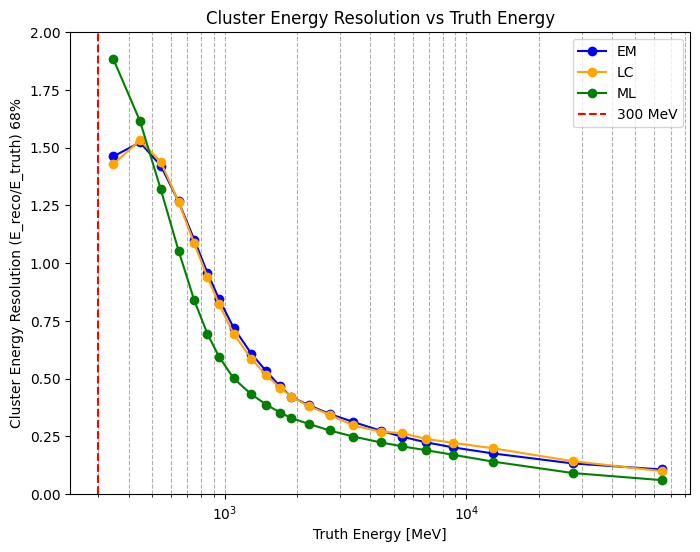

In [4]:
# plot the resolutions vs actual truth energy using bins
plt.figure(figsize=(8,6))


sigma_em_bins, sigma_lc_bins, sigma_ml_bins = [], [], []
bin_centers_truth = []

for low, high in zip(bin_edges[:-1], bin_edges[1:]):
    mask = (df["fCluster_truthE"] >= low) & (df["fCluster_truthE"] < high)
    if mask.sum() > 0:
        sigma_em_bins.append(relative_resolution_68(df.loc[mask, "response_em"]))
        sigma_lc_bins.append(relative_resolution_68(df.loc[mask, "response_lc"]))
        sigma_ml_bins.append(relative_resolution_68(df.loc[mask, "response_ml"]))
        # Use median truth energy in the bin as x-value
        bin_centers_truth.append(np.median(df.loc[mask, "fCluster_truthE"]))

sigma_em_bins = np.array(sigma_em_bins)
sigma_lc_bins = np.array(sigma_lc_bins)
sigma_ml_bins = np.array(sigma_ml_bins)
bin_centers_truth = np.array(bin_centers_truth)

plt.plot(bin_centers_truth, sigma_em_bins, label='EM', marker='o', color='blue', linewidth=1.5)
plt.plot(bin_centers_truth, sigma_lc_bins, label='LC', marker='o', color='orange', linewidth=1.5)
plt.plot(bin_centers_truth, sigma_ml_bins, label='ML', marker='o', color='green', linewidth=1.5)

# put a line at 300 MeV
plt.axvline(x=300, color='r', linestyle='--', label='300 MeV')
plt.yscale('linear')
plt.xscale('log')
plt.ylim(0, 2.0)
plt.xlabel('Truth Energy [MeV]')
plt.ylabel('Cluster Energy Resolution (E_reco/E_truth) 68%')
plt.title('Cluster Energy Resolution vs Truth Energy')
plt.legend()
plt.grid(True, which="both", ls="--", axis='x')
plt.savefig("cluster_energy_resolution_vs_truth_energy.png")
plt.show()

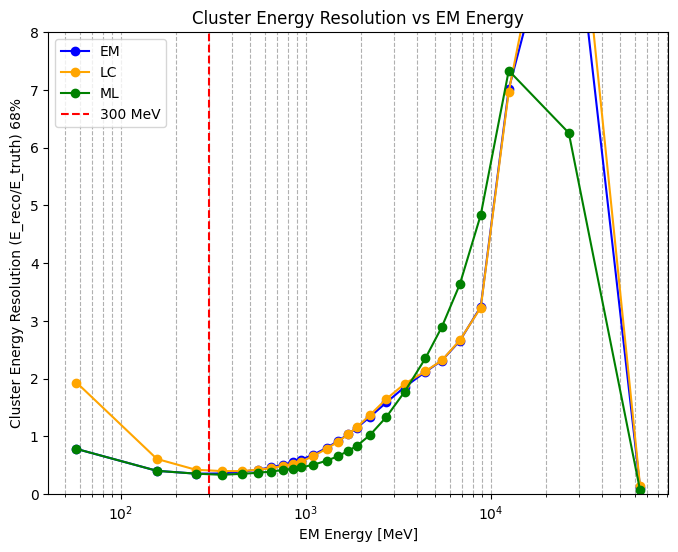

In [5]:
# resolution as a function of EM energy
plt.figure(figsize=(8,6))

sigma_em_bins, sigma_lc_bins, sigma_ml_bins = [], [], []
bin_centers_truth = []

for low, high in zip(bin_edges[:-1], bin_edges[1:]):
    mask = (df["fCluster_rawE"] >= low) & (df["fCluster_rawE"] < high)
    if mask.sum() > 0:
        sigma_em_bins.append(relative_resolution_68(df.loc[mask, "response_em"]))
        sigma_lc_bins.append(relative_resolution_68(df.loc[mask, "response_lc"]))
        sigma_ml_bins.append(relative_resolution_68(df.loc[mask, "response_ml"]))
        # Use median EM energy in the bin as x-value
        bin_centers_truth.append(np.median(df.loc[mask, "fCluster_rawE"]))

sigma_em_bins = np.array(sigma_em_bins)
sigma_lc_bins = np.array(sigma_lc_bins)
sigma_ml_bins = np.array(sigma_ml_bins)
bin_centers_truth = np.array(bin_centers_truth)

plt.plot(bin_centers_truth, sigma_em_bins, label='EM', marker='o', color='blue', linewidth=1.5)
plt.plot(bin_centers_truth, sigma_lc_bins, label='LC', marker='o', color='orange', linewidth=1.5)
plt.plot(bin_centers_truth, sigma_ml_bins, label='ML', marker='o', color='green', linewidth=1.5)

# put a line at 300 MeV
plt.axvline(x=300, color='r', linestyle='--', label='300 MeV')
plt.yscale('linear')
plt.xscale('log')
plt.ylim(0, 8.0)
plt.xlabel('EM Energy [MeV]')
plt.ylabel('Cluster Energy Resolution (E_reco/E_truth) 68%')
plt.title('Cluster Energy Resolution vs EM Energy')
plt.legend()
plt.grid(True, which="both", ls="--", axis='x')
plt.savefig("cluster_energy_resolution_vs_em_energy.png")
plt.show()

In [ ]:
# median response as a function of truth energy
plt.figure(figsize=(8,6))

median_em_bins, median_lc_bins, median_ml_bins = [], [], []
bin_centers_truth = []

for low, high in zip(bin_edges[:-1], bin_edges[1:]):
    mask = (df["fCluster_truthE"] >= low) & (df["fCluster_truthE"] < high)
    if mask.sum() > 0:
        median_em_bins.append(median_response(df.loc[mask, "response_em"]))
        median_lc_bins.append(median_response(df.loc[mask, "response_lc"]))
        median_ml_bins.append(median_response(df.loc[mask, "response_ml"]))
        # Use median truth energy in the bin as x-value
        bin_centers_truth.append(np.median(df.loc[mask, "fCluster_truthE"]))

median_em_bins = np.array(median_em_bins)
median_lc_bins = np.array(median_lc_bins)
median_ml_bins = np.array(median_ml_bins)
bin_centers_truth = np.array(bin_centers_truth)

plt.plot(bin_centers_truth, median_em_bins, label='EM', marker='o', color='blue', linewidth=1.5)
plt.plot(bin_centers_truth, median_lc_bins, label='LC', marker='o', color='orange', linewidth=1.5)
plt.plot(bin_centers_truth, median_ml_bins, label='ML', marker='o', color='green', linewidth=1.5)

# put a line at 300 MeV
plt.axvline(x=300, color='r', linestyle='--', label='300 MeV')
plt.yscale('linear')
plt.xscale('log')
plt.ylim(0, 5.0)
plt.xlabel('Truth Energy [MeV]')
plt.ylabel('Cluster Energy Median Response (E_reco/E_truth)')
plt.title('Cluster Energy Median Response vs Truth Energy')
plt.legend()
plt.grid(True, which="both", ls="--", axis='x')
plt.savefig("cluster_energy_median_response_vs_truth_energy.png")
plt.show()

NameError: name 'plt' is not defined

: 

: 

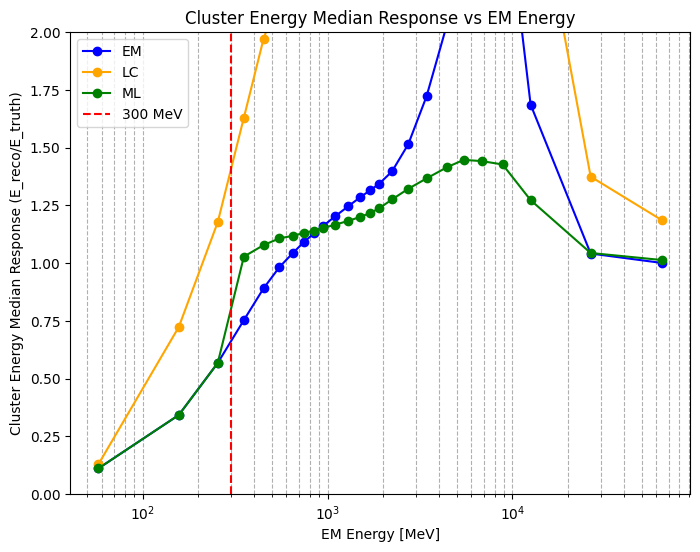

In [6]:

# median response as a function of EM energy
plt.figure(figsize=(8,6))

median_em_bins, median_lc_bins, median_ml_bins = [], [], []
bin_centers_truth = []

for low, high in zip(bin_edges[:-1], bin_edges[1:]):
    mask = (df["fCluster_rawE"] >= low) & (df["fCluster_rawE"] < high)
    if mask.sum() > 0:
        median_em_bins.append(median_response(df.loc[mask, "response_em"]))
        median_lc_bins.append(median_response(df.loc[mask, "response_lc"]))
        median_ml_bins.append(median_response(df.loc[mask, "response_ml"]))
        # Use median EM energy in the bin as x-value
        bin_centers_truth.append(np.median(df.loc[mask, "fCluster_rawE"]))

median_em_bins = np.array(median_em_bins)
median_lc_bins = np.array(median_lc_bins)
median_ml_bins = np.array(median_ml_bins)
bin_centers_truth = np.array(bin_centers_truth)

plt.plot(bin_centers_truth, median_em_bins, label='EM', marker='o', color='blue', linewidth=1.5)
plt.plot(bin_centers_truth, median_lc_bins, label='LC', marker='o', color='orange', linewidth=1.5)
plt.plot(bin_centers_truth, median_ml_bins, label='ML', marker='o', color='green', linewidth=1.5)

# put a line at 300 MeV
plt.axvline(x=300, color='r', linestyle='--', label='300 MeV')
plt.yscale('linear')
plt.xscale('log')
plt.ylim(0, 2.0)
plt.xlabel('EM Energy [MeV]')
plt.ylabel('Cluster Energy Median Response (E_reco/E_truth)')
plt.title('Cluster Energy Median Response vs EM Energy')
plt.legend()
plt.grid(True, which="both", ls="--", axis='x')
plt.savefig("cluster_energy_median_response_vs_em_energy.png")
plt.show()

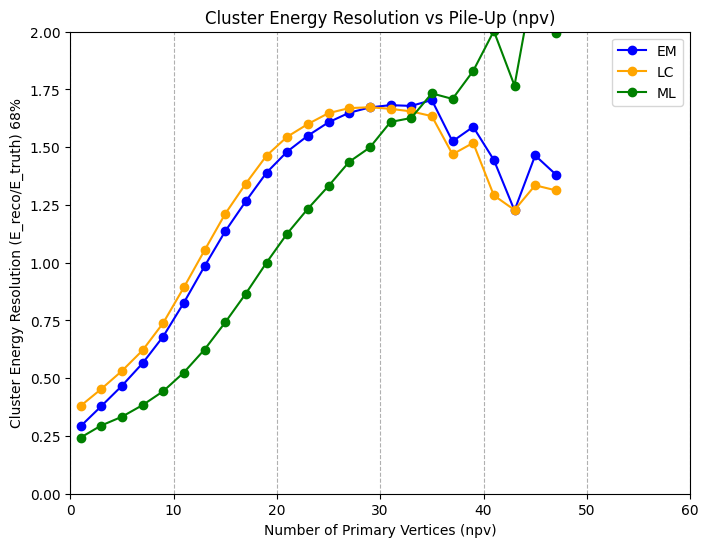

In [7]:
# resolution as a function of npv
plt.figure(figsize=(8,6))
bin_edges_npv = np.arange(0, 62, 2)  # 0 to 60 in steps of 2
sigma_em_bins_npv, sigma_lc_bins_npv, sigma_ml_bins_npv = [], [], []
bin_centers_npv = []
for low, high in zip(bin_edges_npv[:-1], bin_edges_npv[1:]):
    mask = (df["npv"] >= low) & (df["npv"] < high)
    if mask.sum() > 0:
        sigma_em_bins_npv.append(relative_resolution_68(df.loc[mask, "response_em"]))
        sigma_lc_bins_npv.append(relative_resolution_68(df.loc[mask, "response_lc"]))
        sigma_ml_bins_npv.append(relative_resolution_68(df.loc[mask, "response_ml"]))
        bin_centers_npv.append((low + high) / 2)
sigma_em_bins_npv = np.array(sigma_em_bins_npv)
sigma_lc_bins_npv = np.array(sigma_lc_bins_npv)
sigma_ml_bins_npv = np.array(sigma_ml_bins_npv)
bin_centers_npv = np.array(bin_centers_npv)
plt.plot(bin_centers_npv, sigma_em_bins_npv, label='EM', marker='o', color='blue', linewidth=1.5)
plt.plot(bin_centers_npv, sigma_lc_bins_npv, label='LC', marker='o', color='orange', linewidth=1.5)
plt.plot(bin_centers_npv, sigma_ml_bins_npv, label='ML', marker='o', color='green', linewidth=1.5)
plt.yscale('linear')
plt.xlabel('Number of Primary Vertices (npv)')
plt.ylabel('Cluster Energy Resolution (E_reco/E_truth) 68%')
plt.title('Cluster Energy Resolution vs Pile-Up (npv)')
plt.ylim(0, 2.0)
plt.xlim(0, 60)
plt.legend()
plt.grid(True, which="both", ls="--", axis='x')
plt.savefig("cluster_energy_resolution_vs_npv.png")
plt.show()

In [8]:
# veryfication: there is no npv value above 50
print(f"Max npv in data: {df['npv'].max()}")

Max npv in data: 46.0


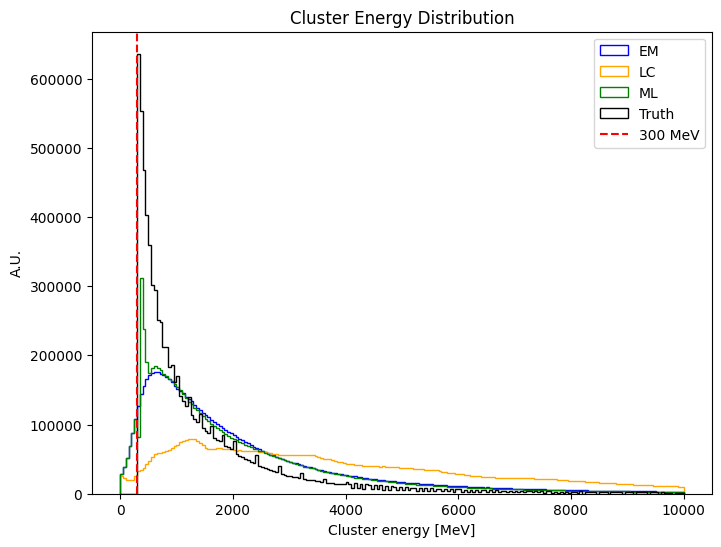

In [9]:
# plot histogram of cluster energy at different scales

min_energy = 0
max_energy = 10000
n_bins = 200


plt.figure(figsize=(8,6))
plt.hist(df["fCluster_rawE"], bins=n_bins, range=(min_energy,max_energy), histtype='step', label='EM', color='blue')#, density=True)
plt.hist(df["fCluster_calE"], bins=n_bins, range=(min_energy,max_energy), histtype='step', label='LC', color='orange')#, density=True)
plt.hist(df["fCluster_MLE"], bins=n_bins, range=(min_energy,max_energy), histtype='step', label='ML', color='green')#, density=True)
plt.hist(df["fCluster_truthE"], bins=n_bins, range=(min_energy,max_energy), histtype='step', label='Truth', color='black')#, density=True)
plt.axvline(x=300, color='r', linestyle='--', label='300 MeV')
#plt.yscale('log')
plt.xlabel('Cluster energy [MeV]')
plt.ylabel('A.U.')
plt.title('Cluster Energy Distribution')
plt.legend()
#plt.yscale('log')
#plt.xscale('log')
#plt.grid(True, which="both", ls="--", axis='x')
plt.savefig("cluster_energy_distribution.png")
# make a line at 300 MeV
plt.show()

AttributeError: Line2D.set() got an unexpected keyword argument 'density'

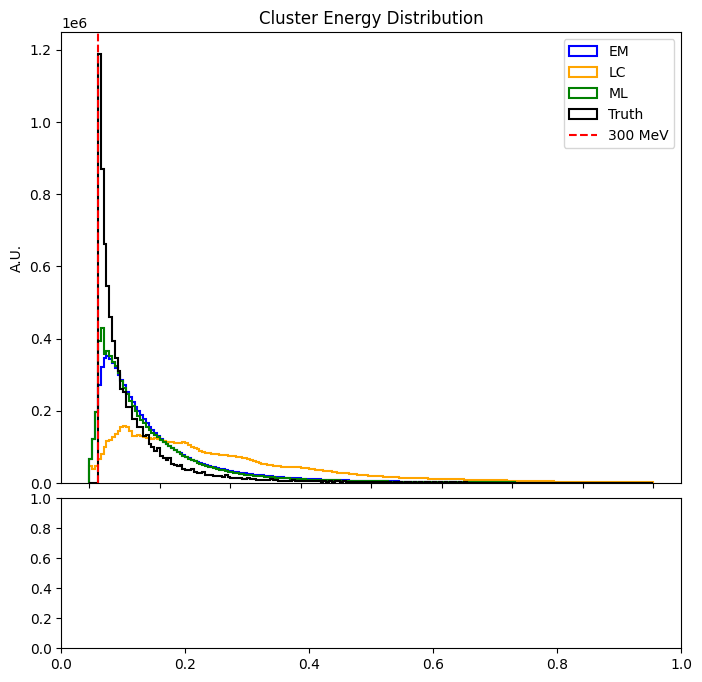

In [ ]:
# plot histogram of cluster energy at different scales with ratio plot

min_energy = 0
max_energy = 20000
n_bins = 200

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), 
                                gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.05})

# Main plot
hist_em, bins, _ = ax1.hist(df["fCluster_rawE"], bins=n_bins, range=(min_energy, max_energy), 
                             histtype='step', label='EM', color='blue', linewidth=1.5)
hist_lc, _, _ = ax1.hist(df["fCluster_calE"], bins=n_bins, range=(min_energy, max_energy), 
                          histtype='step', label='LC', color='orange', linewidth=1.5)
hist_ml, _, _ = ax1.hist(df["fCluster_MLE"], bins=n_bins, range=(min_energy, max_energy), 
                          histtype='step', label='ML', color='green', linewidth=1.5)
hist_truth, _, _ = ax1.hist(df["fCluster_truthE"], bins=n_bins, range=(min_energy, max_energy), 
                             histtype='step', label='Truth', color='black', linewidth=1.5)

ax1.axvline(x=300, color='r', linestyle='--', label='300 MeV')
ax1.set_ylabel('A.U.')
ax1.set_title('Cluster Energy Distribution')
ax1.legend()
ax1.tick_params(axis='x', labelbottom=False)

# Ratio plot
bin_centers = (bins[:-1] + bins[1:]) / 2

# Calculate ratios (avoid division by zero)
mask_nonzero = hist_truth > 0
ratio_em = np.ones_like(hist_em)
ratio_lc = np.ones_like(hist_lc)
ratio_ml = np.ones_like(hist_ml)

ratio_em[mask_nonzero] = hist_em[mask_nonzero] / hist_truth[mask_nonzero]
ratio_lc[mask_nonzero] = hist_lc[mask_nonzero] / hist_truth[mask_nonzero]
ratio_ml[mask_nonzero] = hist_ml[mask_nonzero] / hist_truth[mask_nonzero]

ax2.plot(bin_centers, ratio_em, color='blue', linewidth=1.5, label='EM/Truth')
ax2.plot(bin_centers, ratio_lc, color='orange', linewidth=1.5, label='LC/Truth')
ax2.plot(bin_centers, ratio_ml, color='green', linewidth=1.5, label='ML/Truth')
ax2.axhline(y=1, color='black', linestyle='-', linewidth=1)
ax2.axvline(x=300, color='r', linestyle='--')

ax2.set_xlabel('Cluster energy [MeV]')
ax2.set_ylabel('Ratio to Truth')
ax2.set_ylim(0.0, 2.0)
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=8)

plt.savefig("cluster_energy_distribution_with_ratio.png", dpi=150, bbox_inches='tight')
plt.show()

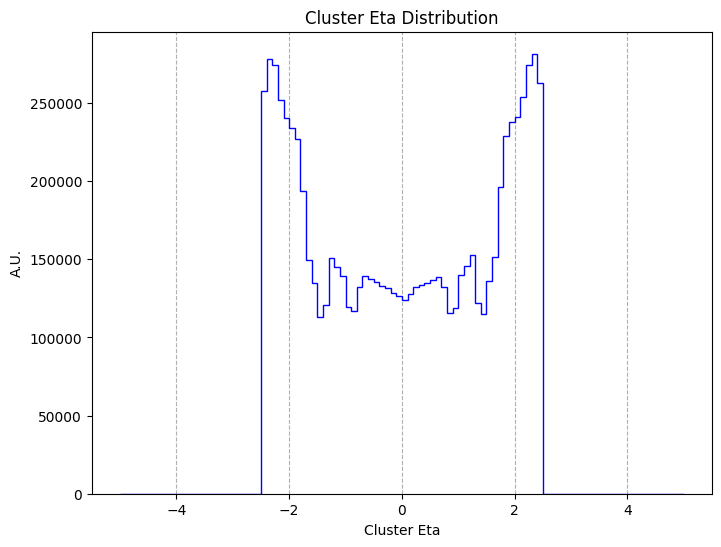

In [14]:
# plot cluster eta distribution
plt.figure(figsize=(8,6))
plt.hist(df["fClusterEta"], bins=100, range=(-5,5), histtype='step', color='blue')
plt.xlabel('Cluster Eta')
plt.ylabel('A.U.')
plt.title('Cluster Eta Distribution')
plt.grid(True, which="both", ls="--", axis='x')
plt.savefig("cluster_eta_distribution.png")
plt.show()

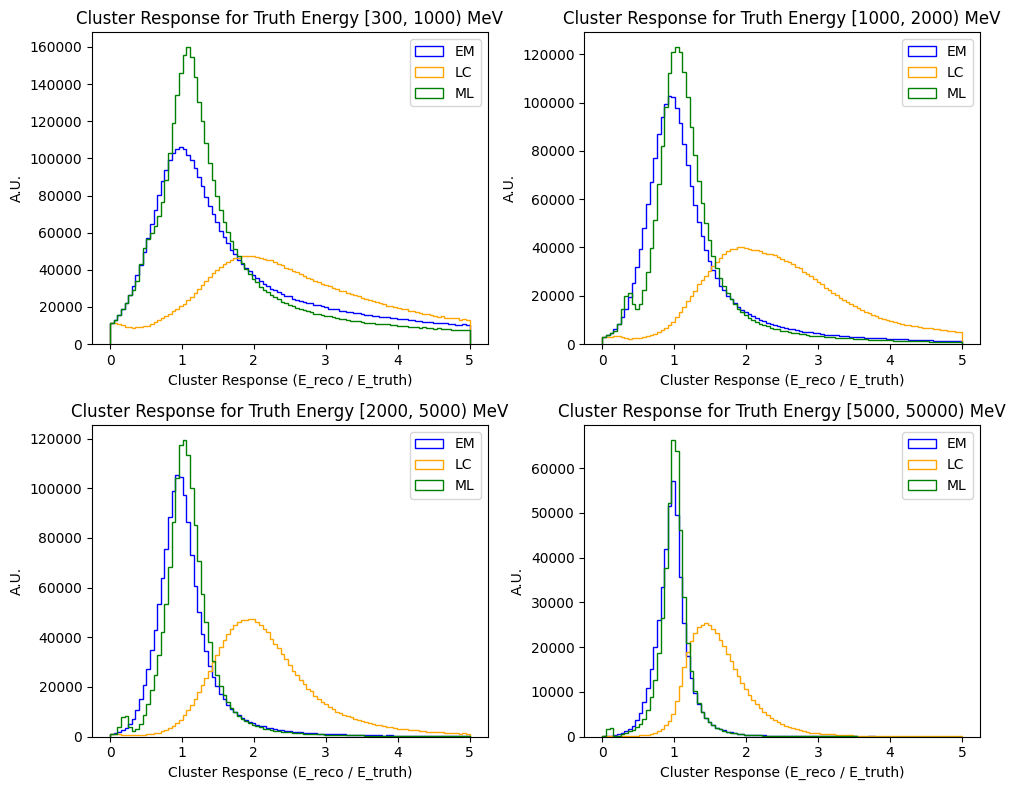

In [15]:
## plot cluster response (E_reco / E_truth) histograms at different energy slices
# use finer binning of 50 MeV
energy_slices = [(300, 1000), (1000, 2000), (2000, 5000), (5000, 50000)]
#energy_slices = [(0, 50000)]
bins_response = np.linspace(0, 5, 100)  # finer bins for response
plt.figure(figsize=(10, 8))
for i, (low, high) in enumerate(energy_slices):
    mask = (df["fCluster_truthE"] >= low) & (df["fCluster_truthE"] < high)
    plt.subplot(2, 2, i+1)
    plt.hist(df.loc[mask, "response_em"], bins=bins_response, histtype='step', label='EM', color='blue')#, density=True)
    plt.hist(df.loc[mask, "response_lc"], bins=bins_response, histtype='step', label='LC', color='orange')#, density=True)
    plt.hist(df.loc[mask, "response_ml"], bins=bins_response, histtype='step', label='ML', color='green')#, density=True)
    plt.xlabel('Cluster Response (E_reco / E_truth)')
    plt.ylabel('A.U.')
    plt.title(f'Cluster Response for Truth Energy [{low}, {high}) MeV')
    plt.legend()
plt.tight_layout()
plt.savefig("cluster_response_slices_1.png")
plt.show()

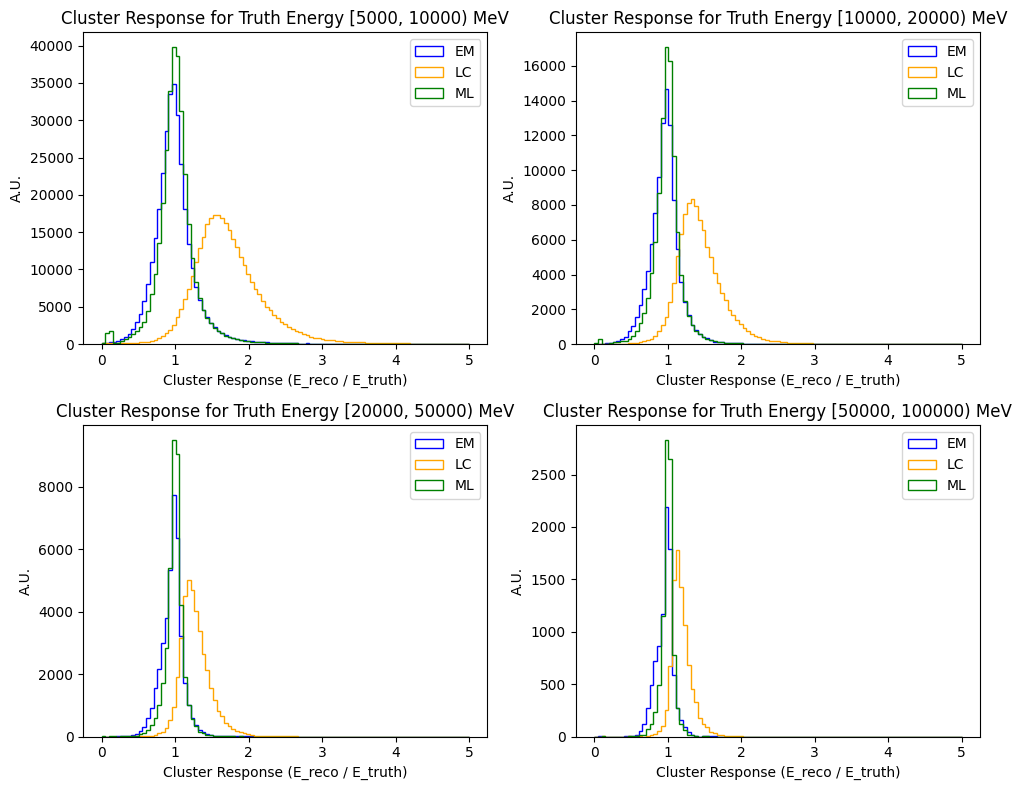

In [16]:
# more plots 
# use finer binning of 50 MeV
energy_slices = [(5000, 10000), (10000, 20000), (20000, 50000), (50000, 100000)]
#energy_slices = [(0, 50000)]
bins_response = np.linspace(0, 5, 100)  # finer bins for response
plt.figure(figsize=(10, 8))
for i, (low, high) in enumerate(energy_slices):
    mask = (df["fCluster_truthE"] >= low) & (df["fCluster_truthE"] < high)
    plt.subplot(2, 2, i+1)
    plt.hist(df.loc[mask, "response_em"], bins=bins_response, histtype='step', label='EM', color='blue')#, density=True)
    plt.hist(df.loc[mask, "response_lc"], bins=bins_response, histtype='step', label='LC', color='orange')#, density=True)
    plt.hist(df.loc[mask, "response_ml"], bins=bins_response, histtype='step', label='ML', color='green')#, density=True)
    plt.xlabel('Cluster Response (E_reco / E_truth)')
    plt.ylabel('A.U.')
    plt.title(f'Cluster Response for Truth Energy [{low}, {high}) MeV')
    plt.legend()
plt.tight_layout()
plt.savefig("cluster_response_slices_2.png")
plt.show()

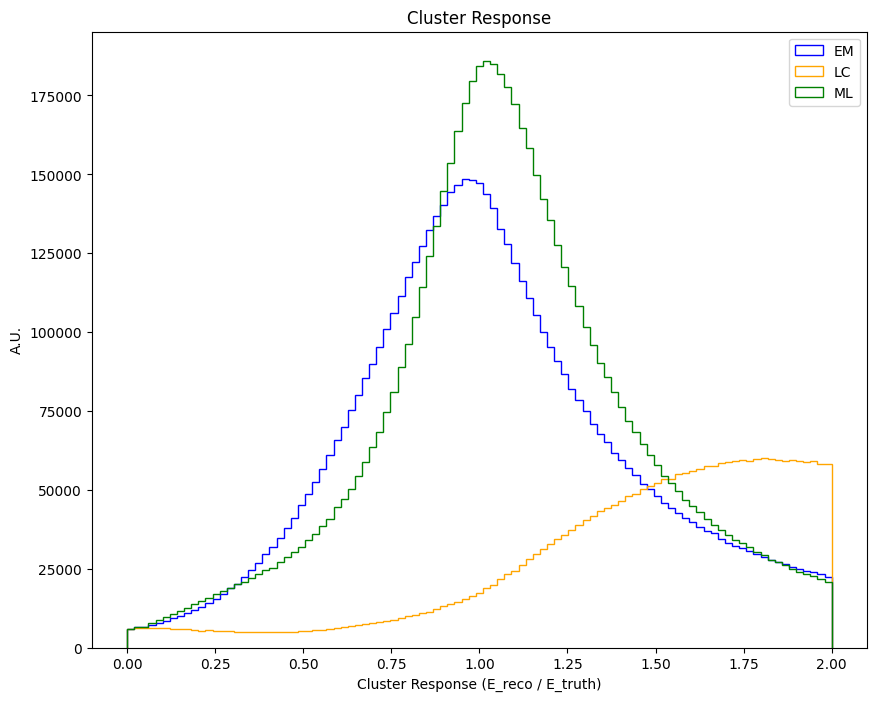

In [17]:
## plot cluster response (E_reco / E_truth) histograms at different energy slices
# use finer binning of 50 MeV
bins_response = np.linspace(0, 2, 100)  # finer bins for response
plt.figure(figsize=(10, 8))
low = 0
high = 50000
mask = (df["fCluster_truthE"] >= low) & (df["fCluster_truthE"] < high)
plt.hist(df.loc[mask, "response_em"], bins=bins_response, histtype='step', label='EM', color='blue')#, density=True)
plt.hist(df.loc[mask, "response_lc"], bins=bins_response, histtype='step', label='LC', color='orange')#, density=True)
plt.hist(df.loc[mask, "response_ml"], bins=bins_response, histtype='step', label='ML', color='green')#, density=True)
plt.xlabel('Cluster Response (E_reco / E_truth)')
plt.ylabel('A.U.')
plt.title(f'Cluster Response')
plt.legend()
plt.savefig("cluster_response.png")
plt.show()